In [1]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=ChatGroq(model="qwen-2.5-32b")

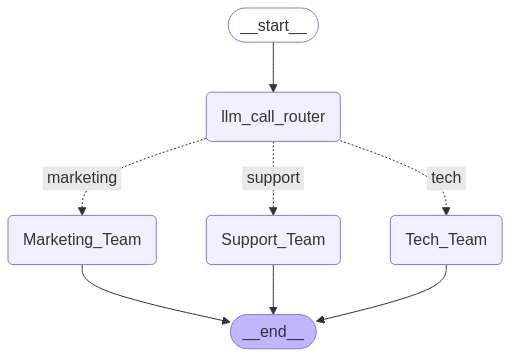

In [21]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

class Route(BaseModel):
    step:Literal["support team","technical team","marketing team"]=Field(
        None,description="The next step of Routing process"
    )

router=llm.with_structured_output(Route)

class State(TypedDict):
    input:str
    decision:str
    output:str

def support(state:State):
    """print that mail body will go to support team"""
    # result = llm.invoke(state["input"])
    return {"output": "Its sent to Support Team"}

def tech(state:State):
    """print that mail body will go to tech team"""
    # result = llm.invoke(state["input"])
    return {"output": "Its sent to Technical Team"}

def marketing(state:State):
    """print that mail body will go to marketing team"""
    # result = llm.invoke(state["input"])
    return {"output": "Its sent to Marketing Team"}

def llm_call_router(state:State):
    dec=router.invoke([
        SystemMessage(content=
                        "You are an AI assistant responsible for routing emails to the correct team. "
                        "Analyze the email content and determine whether it should be sent to the Support Team, Technical Team, or Marketing Team. "
                        "Use the following criteria:\n\n"
                        "- **Support Team**: Handles customer service inquiries, order issues, and general support requests.\n"
                        "- **Technical Team**: Resolves technical problems such as system errors, login issues, and software bugs.\n"
                        "- **Marketing Team**: Manages promotional campaigns, collaborations, and brand partnerships.\n\n"),
        HumanMessage(content=state['input'])
    ])
    return {'decision':dec.step}

def router_decision(state:State):
    if state['decision']=="support team":
        return "support"
    elif state['decision']=="technical team":
        return "tech"
    elif state['decision']=="marketing team":
        return "marketing"


builder=StateGraph(State)

builder.add_node("Support_Team",support)
builder.add_node("Tech_Team",tech)
builder.add_node("Marketing_Team",marketing)
builder.add_node("llm_call_router",llm_call_router)

builder.add_edge(START, "llm_call_router")
builder.add_conditional_edges(
    "llm_call_router",
    router_decision,
    {
        "tech":"Tech_Team",
        "support":"Support_Team",
        "marketing":"Marketing_Team"
    }
)
builder.add_edge("Support_Team",END)
builder.add_edge("Tech_Team",END)
builder.add_edge("Marketing_Team",END)

router_workflow=builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [16]:
response=router_workflow.invoke({"input":"""I am facing an issue with logging into my account on our company portal. Every time I enter my credentials, I receive an "Invalid Credentials" error, even though I am sure my details are correct. I also tried resetting my password, but the reset link isn’t working.

Could you please look into this issue and help me regain access?"""})
response['output']

'Its sent to Technical Team'

In [17]:
response=router_workflow.invoke({"input":"""I am reaching out to explore potential collaboration opportunities between our brands. We believe a partnership could be mutually beneficial, especially given our shared audience.

Could we schedule a meeting to discuss how we can work together? Looking forward to your thoughts."""})
response['output']

'Its sent to Marketing Team'

In [18]:
response=router_workflow.invoke({"input":"""I recently placed an order (#12345) on your website, but I haven't received any updates regarding the shipping status. The estimated delivery date has passed, and the tracking link isn't showing any details.

Could you please check the status and provide an update?"""})
response['output']

'Its sent to Support Team'